## First step: imports and initialise the SEVNmanager
Intialise the SEVNmanager at the beginning of your script

In [116]:
import numpy as np
import matplotlib.pyplot as plt
from fireworks.particles import Particles
from fireworks.nbodylib.nunits import Nbody_units
from fireworks.ic import ic_two_body
from fireworks.nbodylib.dynamics import acceleration_estimate_direct, acceleration_estimate_direct_wjerk, get_newton_jerk_accacceleration_estimate_direct
from fireworks.nbodylib.integrators import integrator_euler, integrator_hermite, integrator_symplectic_euler, integrator_symplectic_leapfrog
from sevnpy.sevn import SEVNmanager, Star
import warnings
warnings.filterwarnings("ignore")

SEVNmanager.init() # Initialsie with default value

## Initial conditions: positions and velocities

Generate initial conditions

In [117]:
# Example with two particles generated from a circual binary  (see Lecture 8)

pos1  = np.array([0.069602, 0.01624699, 0.0]) # in parsec 
vel1  = np.array([-0.09977189698445348, 0.4274221388841862, 0.0]) # in km/s
mass1 = 30 # In Msun 

pos2  = np.array([-0.10440299, -0.02437049, 0.0]) # in parsec 
vel2  = np.array([0.1496578454766802, -0.6411332083262792, 0.0]) # in km/s
mass2 = 20 # In Msun 



# Transform to Nbody units and create the fireworks particles 
## Define the Nbody units class, 
## Since the positions of the stars are of the order of pc, let'use the standad units
## pc,Myr,km/s
nu=Nbody_units(M=1, L=1) 
pos1_nb  = nu.pos_to_Nbody(pos1)
vel1_nb  = nu.vel_to_Nbody(vel1)
pos2_nb  = nu.pos_to_Nbody(pos2)
vel2_nb  = nu.vel_to_Nbody(vel2)
mass1_nb = nu.m_to_Nbody(mass1)
mass2_nb = nu.m_to_Nbody(mass2)

#Finaly generate the particle orbits
part=Particles(position=np.array([pos1_nb,pos2_nb]),velocity=np.array([vel1_nb,vel2_nb]),mass=np.array([mass1_nb,mass2_nb]))


## Initial conditions: Stars

Initialise the stars and then evolve them so that we can exploit the property interpolation 

In [143]:
# Initialise the Sevn Star objects and put it on a list assume Z=0.02 as metallicity
stars_list = [Star(Mzams=mass1, Z=0.02,rseed=100), Star(Mzams=mass2,Z=0.02,rseed=1000)]

## Evolution 
Finally, we can evolve the sytems combining the dynamical evolution with the stellar evolution

Min stellar life 5.91791954


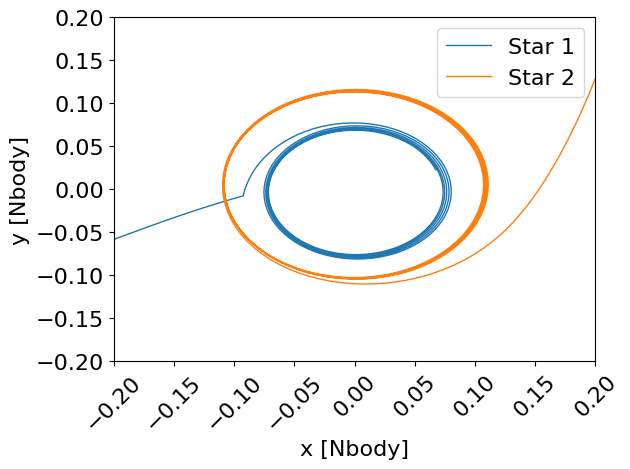

0.6344079752801841


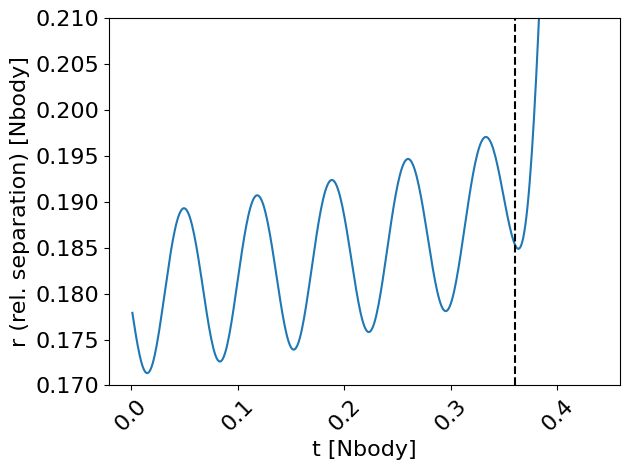

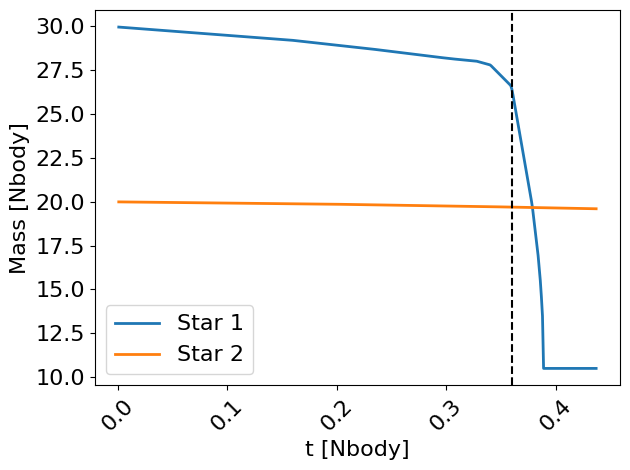

In [174]:
stars_list = [Star(Mzams=mass1, Z=0.02,rseed=100), Star(Mzams=mass2,Z=0.02,rseed=1000)]
# To set the simulations ending time let's find what is the tlife of the stars
tlife_min = np.min([stars_list[0].tlife,stars_list[1].tlife])
print("Min stellar life", tlife_min)


# Now transform a fraciton of this time in Nbody units 
Tend_nb = 1.1*nu.t_to_Nbody(tlife_min) #Nbody units
dt_nb = 0.001 #Nbody untis
t=0 

part=Particles(position=np.array([pos1_nb,pos2_nb]),velocity=np.array([vel1_nb,vel2_nb]),mass=np.array([mass1_nb,mass2_nb]))


pos=[]
tl=[]
m1l=[]
m2l=[]

#evolution
while(t<Tend_nb):
    # Update time
    t+=dt_nb
    
    # Step-1 Dyanmica evolution: update positions
    part,_,_,_,_=integrator_symplectic_euler(particles=part,acceleration_estimator=acceleration_estimate_direct,tstep=dt_nb)
    
    pos.append(part.pos)
    
    # Step-2 Get new propertied from star and update stellar properteis (e.g. mass)
    dt_physics = nu.t_to_physical(dt_nb)  # SEVN works in physical units
    
    for i in range(len(stars_list)):
        
        # Save the previous stellar phase to check for SN explosion (see below)
        previous_type = stars_list[i].getp_array("Phase",mode="last")[0]
        
        # Evolve star and update the particles mass
        stars_list[i].evolve_for(dt_physics)
        updated_mass = stars_list[i].getp_array("Mass",mode="last")[0]
        part.mass[i]=nu.m_to_Nbody(updated_mass)
        
        # Check the current stellar phase to check for SN explosion (see below)
        new_type = stars_list[i].getp_array("Phase",mode="last")[0]
        
        # If new phase is 7 (i.e. remnant) and previous not, apply kick
        if new_type==7 and previous_type!=7:
        
            vkick = stars_list[i].get_SN_kick()["Vkick"]
            
            # If there are nan (because for example a WD has been formed skip  the kick update)
            if np.any(np.isnan(vkick)): 
                pass 
            else:
                # apply kick
                part.vel[i] = part.vel[i] + vkick
        
    
    m1l.append(part.mass[0])
    m2l.append(part.mass[1])
    tl.append(t)
    
tl=np.array(tl)
pos=np.array(pos)


plt.plot(pos[:,0,0],pos[:,0,1],label="Star 1",lw=1)
plt.plot(pos[:,1,0],pos[:,1,1], label="Star 2",lw=1)
plt.xlim(-0.2,0.2)
plt.ylim(-0.2,0.2)
plt.xticks(fontsize=16,rotation=45)
plt.yticks(fontsize=16)
plt.xlabel("x [Nbody]",fontsize=16)
plt.ylabel("y [Nbody]",fontsize=16)
plt.legend(fontsize=16)
plt.tight_layout()
plt.savefig("fw_sevn_bin.pdf")
plt.show()


r=np.sqrt(np.sum( (pos[:,0,:]-pos[:,1,:])**2, axis=1 ))
plt.plot(tl,r)
print((np.max(r)-np.min(r))/(np.max(r)+np.min(r)))
plt.xticks(fontsize=16,rotation=45)
plt.yticks(fontsize=16)
plt.xlabel("t [Nbody]",fontsize=16)
plt.ylabel("r (rel. separation) [Nbody]",fontsize=16)
plt.ylim(0.17,0.21)
plt.axvline(0.36,ls="dashed",c="k")
plt.tight_layout()
plt.savefig("fw_sevn_rad.pdf")
plt.show()

plt.plot(tl,m1l,label="Star 1",lw=2)
plt.plot(tl,m2l, label="Star 2",lw=2)
plt.xticks(fontsize=16,rotation=45)
plt.yticks(fontsize=16)
plt.xlabel("t [Nbody]",fontsize=16)
plt.ylabel("Mass [Nbody]",fontsize=16)
plt.legend(fontsize=16)
plt.axvline(0.36,ls="dashed",c="k")
plt.tight_layout()
plt.savefig("fw_sevn_mass.pdf")
plt.show()